In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import logging

#model building
import torch
import torchvision
from torchvision.transforms import v2
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from time import sleep
from torch.optim.lr_scheduler import StepLR


#plotting and evalueation
import seaborn as sns


DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
def pre_preprocessing(train_path, test_path, test):

    #reading data 
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)

    #Stripping the whitespace from columns 
    train_df.rename(columns = lambda x: x.strip(), inplace = True)
    test_df.rename(columns = lambda x: x.strip(), inplace = True)

    #Subtracting 1 from each value in target column to scale to 0 or1 
    y_train = (train_df["TARGET"]-1).to_numpy()
    
    #Saving the ID values
    train_ids = train_df["ID"]
    test_ids = test_df["ID"]

    #Dropping the ID colmn
    train_df = train_df.drop('ID', axis = 1)
    test_df = test_df.drop('ID', axis = 1)

    #Creating some additional features
    train_df["NDVI"] = (train_df["nir_p50"] - train_df["red_p50"])/ (train_df["nir_p50"] + train_df["red_p50"])     #Normalized Difference Vegetation Index
    train_df["NDWI"] = (train_df["nir_p50"] - train_df["swir1_p50"])/ (train_df["nir_p50"] + train_df["swir1_p50"])    #Normalized Difference Water Index
    train_df["red_green_ratio"] = train_df["red_p50"]/train_df["green_p50"] + 1e-6
    train_df["NIR_green_ratio"] = train_df["nir_p50"]/train_df["green_p50"]+ 1e-6
    train_df["blue_red_ratio"] = train_df["blue_p50"]/train_df["red_p50"]+ 1e-6
    train_df["swir_ratio"] = train_df["swir1_p50"]/train_df["swir2_p50"]+ 1e-6
    train_df["VV_VH_ratio"] = train_df["VV_p50"]/train_df["VH_p50"]+ 1e-6

    test_df["NDVI"] = (test_df["nir_p50"] - test_df["red_p50"])/ (test_df["nir_p50"] + test_df["red_p50"])     #Normalized Difference Vegetation Index
    test_df["NDWI"] = (test_df["nir_p50"] - test_df["swir1_p50"])/ (test_df["nir_p50"] + test_df["swir1_p50"])    #Normalized Difference Water Index
    test_df["red_green_ratio"] = test_df["red_p50"]/test_df["green_p50"]
    test_df["NIR_green_ratio"] = test_df["nir_p50"]/test_df["green_p50"]
    test_df["blue_red_ratio"] = test_df["blue_p50"]/test_df["red_p50"]
    test_df["swir_ratio"] = test_df["swir1_p50"]/test_df["swir2_p50"]
    test_df["VV_VH_ratio"] = test_df["VV_p50"]/test_df["VH_p50"]



    print(x_train.isna().sum())
    print(x_test.isna().sum())



    #If running on with evalution (less training data)
    if test == False:
        #splitting into train and eval sets
        x_train, x_eval, y_train, y_eval = train_test_split(train_df, y_train,random_state=0, train_size =.75)

        #convering to Numpy arrays
        x_train = x_train.to_numpy()
        x_eval = x_eval.to_numpy()
        x_test = test_df.to_numpy()


        #normalizing the data 
        scaler = preprocessing.StandardScaler()
        x_train = preprocessing.normalize(x_train)
        x_test = preprocessing.normalize(x_test)
        x_eval = preprocessing.normalize(x_eval)

        #Converting to Torch Tensors
        x_train = torch.from_numpy(x_train).type(torch.float)
        y_train = torch.from_numpy(y_train).type(torch.long)
        x_eval = torch.from_numpy(x_eval).type(torch.float)
        y_eval = torch.from_numpy(y_eval).type(torch.long)
        x_test = torch.from_numpy(x_test).type(torch.float)

        return x_train, y_train, x_eval, y_eval, x_test, test_ids
    else:
        #convering to Numpy arrays
        x_train = train_df.to_numpy()
        x_test = test_df.to_numpy()

        #normalizing the data 
        scaler = preprocessing.StandardScaler()
        x_train = preprocessing.normalize(x_train)
        x_test = preprocessing.normalize(x_test)

        #Converting to Torch Tensors
        x_train = torch.from_numpy(x_train).type(torch.float)
        y_train = torch.from_numpy(y_train).type(torch.long)
        x_test = torch.from_numpy(x_test).type(torch.float)

        return x_train, y_train, x_test, test_ids

**Custom Dataset Class**

In [3]:
#Defining Custom Dataset
class CountryDataset(Dataset):
    def __init__(self, x, y):
        self.features = x
        self.labels = y

    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self. labels[idx]


**Model Class**

In [4]:
#Creating the Module
class First_Model(nn.Module):
    def __init__(self,n_features):
        super(First_Model, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(n_features, 128),  # Input size n_features
            nn.Dropout(0.15),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.Dropout(0.15),
            nn.ReLU(),
            nn.Linear(256, 1),   # Output size is 1 for binary classification
            nn.Sigmoid()         # Use Sigmoid for binary classification
        )

    def forward(self, x):
        return self.net(x)


**Function for training the model**

In [5]:
def training(model, loss_fn, train_loader, opt, epochs = 3000):
    running_losses = []
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0 
        for i, (datapoints, labels) in enumerate(tqdm(train_loader)):
            #forward proporgation
            outputs = model(datapoints)

            labels = labels.float().unsqueeze(1)
            loss = loss_fn(outputs, labels)

            #backpropogation
            opt.zero_grad()
            loss.backward()
            opt.step()

            epoch_loss+=loss.item()
        running_losses.append(epoch_loss/len(train_loader)) #adding epoch_loss len(train_loader) is batch size
            # if (i+1) %10 == 0:
            #     print(f"epoch number {epoch+1}, loss = {loss.item()}")
    print("Training Finished")
    return running_losses


**Function to Calculate Accuracy of the Model**

In [14]:
def calculate_eval_accuracy(model, eval_loader):
    model.eval()  
    correct = 0
    total = 0

    with torch.no_grad():
        for datapoints, labels in eval_loader:
            outputs = model(datapoints)

            #values between 0 and 1
            probabilities = torch.sigmoid(outputs)

            #binary classification
            predicted = (probabilities > 0.5).float()

            #adjusting shape
            labels = labels.unsqueeze(1)

            correct += (predicted == labels).sum().item()
            total += labels.size(0)


    accuracy = 100 * correct / total
    print(f"Test Accuracy:q {accuracy}%")
    return accuracy

**Preproccessing Data**

In [7]:
x_train_kenya, y_train_kenya,x_eval_kenya, y_eval_kenya,kenya_test_df, kenya_test_ids = pre_preprocessing(train_path = "geoai-challenge-for-agricultural-plastic-cover-mapping-with-satellite-imagery20240708-24674-1c1nnx3/Kenya_training.csv",
                                                                                test_path = "geoai-challenge-for-agricultural-plastic-cover-mapping-with-satellite-imagery20240708-24674-1c1nnx3/Kenya_testing.csv",
                                                                                test = False)


**Instantiating Custom Dataset**

In [8]:
batch_size = 16

#Creating Custom Datasets
train_dataset_kenya = CountryDataset(x_train_kenya, y_train_kenya)
eval_data_set_kenya = CountryDataset(x_eval_kenya, y_eval_kenya)

#creating custom DataLoaders
kenya_train_dl = DataLoader(train_dataset_kenya, batch_size = batch_size, shuffle = True)
kenya_eval_dl = DataLoader(eval_data_set_kenya, batch_size= batch_size, shuffle = False)

In [9]:
n_features = x_train_kenya.shape[1]

model = First_Model(n_features = n_features)
loss_function  = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)
# scheduler = StepLR(optimizer, step_size = 50, gamma = 0.1)

running_losses = training(model = model, loss_fn = loss_function, train_loader = kenya_train_dl,opt = optimizer)

accuracy =  calculate_eval_accuracy(model, kenya_eval_dl)

100%|██████████| 47/47 [00:00<00:00, 1889.00it/s]

Training Finished
PREDICTED torch.Size([16, 1])
PREDICTED torch.Size([16, 1])
PREDICTED torch.Size([16, 1])
PREDICTED torch.Size([16, 1])
PREDICTED torch.Size([16, 1])
PREDICTED torch.Size([16, 1])
PREDICTED torch.Size([16, 1])
PREDICTED torch.Size([16, 1])
PREDICTED torch.Size([16, 1])
PREDICTED torch.Size([16, 1])
PREDICTED torch.Size([16, 1])
PREDICTED torch.Size([16, 1])
PREDICTED torch.Size([16, 1])
PREDICTED torch.Size([16, 1])
PREDICTED torch.Size([16, 1])
PREDICTED torch.Size([10, 1])
Test Accuracy:q 97.2%


**Validation Plots**

In [15]:
def validation_plot(losses):
    num_iterations = np.arange(0, len(losses), 100)  
    losses = [x for i, x in enumerate(losses) if (i%10) == 0]
    plt.plot(losses)
    plt.xlabel("epoch")
    plt.ylabel("Loss")
    plt.title("Validation Plot")
    plt.show()


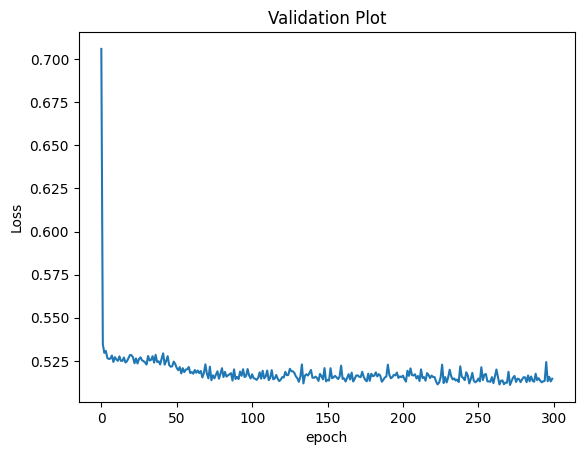

In [11]:
validation_plot(running_losses)

**Create Submission**

In [24]:
def test_predictions(model, test_loader):
    model.eval()  
    all_batches_predictions = torch.empty(0,1)

    with torch.no_grad():
        for datapoints in test_loader:
            outputs = model(datapoints)

            #values between 0 and 1
            probabilities = torch.sigmoid(outputs)

            #binary classification
            predicted = (probabilities > 0.5).float()

            all_batches_predictions = torch.cat((all_batches_predictions, predicted))

    all_predictions = all_batches_predictions.tolist()
    return all_predictions


In [25]:
def create_submission():
    #hyperparameters
    batch_size = 16
    epochs = 3000
    alpha = 0.001

    #reading data
    x_train_kenya, y_train_kenya,kenya_test_df, kenya_test_ids = pre_preprocessing(train_path = "geoai-challenge-for-agricultural-plastic-cover-mapping-with-satellite-imagery20240708-24674-1c1nnx3/Kenya_training.csv",
                                                                                test_path = "geoai-challenge-for-agricultural-plastic-cover-mapping-with-satellite-imagery20240708-24674-1c1nnx3/Kenya_testing.csv", 
                                                                                test = True)
    
    x_train_vnm, y_train_vnm,vnm_test_df, vnm_test_ids = pre_preprocessing(train_path = "geoai-challenge-for-agricultural-plastic-cover-mapping-with-satellite-imagery20240708-24674-1c1nnx3/VNM_training.csv",
                                                                                              test_path = "geoai-challenge-for-agricultural-plastic-cover-mapping-with-satellite-imagery20240708-24674-1c1nnx3/Spain_validation.csv",
                                                                                              test = True)

    x_train_spain, y_train_spain,spain_test_df, spain_test_ids = pre_preprocessing(train_path = "geoai-challenge-for-agricultural-plastic-cover-mapping-with-satellite-imagery20240708-24674-1c1nnx3/Spain_training.csv",
                                                                                                              test_path = "geoai-challenge-for-agricultural-plastic-cover-mapping-with-satellite-imagery20240708-24674-1c1nnx3/Spain_validation.csv",
                                                                                                              test =True)
    #Creating Custom Datasets
    train_dataset_kenya = CountryDataset(x_train_kenya, y_train_kenya)
    train_data_set_vnm = CountryDataset(x_train_vnm, y_train_vnm)
    train_data_set_spain = CountryDataset(x_train_spain, y_train_spain)

    #creating custom DataLoaders
    kenya_train_dl = DataLoader(train_dataset_kenya, batch_size = batch_size, shuffle = True)
    kenya_test_dl = DataLoader(kenya_test_df, batch_size= batch_size, shuffle = False)
    vnm_train_dl = DataLoader(train_data_set_vnm, batch_size = batch_size, shuffle = True)
    vnm_test_dl = DataLoader(vnm_test_df, batch_size= batch_size, shuffle = False)
    spain_train_dl = DataLoader(train_data_set_spain, batch_size = batch_size, shuffle = True)
    spain_test_dl = DataLoader(spain_test_df, batch_size= batch_size, shuffle = False)

    #running
    n_features = x_train_kenya.shape[1]

    model = First_Model(n_features = n_features)
    loss_function  = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)


    running_losses = training(model = model, loss_fn = loss_function, train_loader = kenya_train_dl,opt = optimizer)
    kenya_outputs =  test_predictions(model, kenya_test_dl)

    running_losses = training(model = model, loss_fn = loss_function, train_loader = vnm_train_dl,opt = optimizer)
    vnm_outputs =  test_predictions(model, vnm_test_dl)

    running_losses = training(model = model, loss_fn = loss_function, train_loader = spain_train_dl,opt = optimizer)
    spain_outputs =  test_predictions(model, spain_test_dl)

    #making output dataframes
    kenya_test_results  = pd.concat([pd.Series(kenya_test_ids), pd.Series(kenya_outputs)], axis = 1)
    vnm_test_results = pd.concat([pd.Series(vnm_test_ids), pd.Series(vnm_outputs)], axis = 1)
    spain_test_results = pd.concat([pd.Series(spain_test_ids), pd.Series(spain_outputs)], axis = 1)

    return kenya_test_results, vnm_test_results, spain_test_results


In [29]:
kenya_test_results, vnm_test_results, spain_test_results  = create_submission()

ValueError: Input contains NaN.